# Introduction on how to use zizou

We start by creating a dummy dataset that we can use for testing later on:

In [ ]:
from zizou.data import MockSDSWaveforms
from obspy import UTCDateTime

# SDS directory to store dummy data as MiniSEED
sds_dir = "/tmp/sds/seismic"
waveform_gen = MockSDSWaveforms(sds_dir=sds_dir)
st = waveform_gen.get_waveforms(net="NZ", site="WIZ", loc="10", comp="HHZ",
                                startdate=UTCDateTime("2024-05-01"),
                                enddate=UTCDateTime("2024-06-01"))

This data can now be loaded and plotted with obspy like any regular seismic data

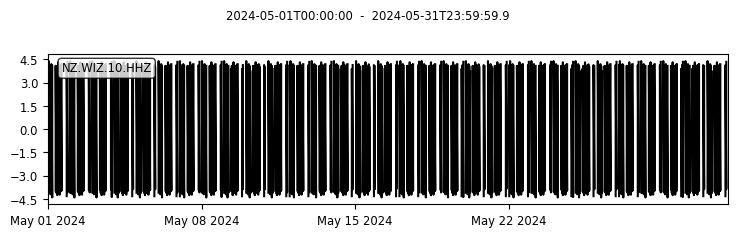

In [4]:
from obspy.clients.filesystem.sds import Client as SDS_Client
client = SDS_Client(sds_dir)
st = client.get_waveforms("NZ", "WIZ", "10", "HHZ", UTCDateTime("2024-05-01"), UTCDateTime("2024-06-01"))
_ = st.plot()

Next we will compute a few typical seismic features and store them using the [tonik](https://tsc-tools.github.io/tonik/) package:

In [ ]:
from zizou.dsar import DSAR
from zizou.rsam import RSAM, EnergyExplainedByRSAM
from zizou.ssam import SSAM
from zizou.spectral_features import SpectralFeatures
from zizou.data import DataSource
from tonik import Storage

import numpy as np
import os 

ds = DataSource(clients=[waveform_gen], chunk_size=86400)

# Instantiate Features 
rsam = RSAM(filtertype='bandpass', filterfreq=(1, 4.9))
rsam_energy_prop = EnergyExplainedByRSAM(filterfreq_wb=(0.5, 4.99))
ssam = SSAM(
    frequencies=np.linspace(0, 4.99, 10),
    timestamp="start", 
    resample_int=(None, "10min")
)
dsar = DSAR(lowerfreqband=(0.1, 2.5), higherfreqband=(2.5, 4.99))
spec = SpectralFeatures()

feature_dir = "/tmp/vumt/features/Whakaari/WIZ/HHZ"
if not os.path.isdir(feature_dir):
    os.makedirs(feature_dir)
sg = Storage('Whakaari', rootdir=feature_dir)
st = sg.get_substore(site='WIZ', sensor='00', channel='HHZ')
for tr in ds.get_waveforms(net="NZ", site="WIZ", loc="10", comp="HHZ", start=UTCDateTime("2024-05-01"), end=UTCDateTime("2024-06-01")):
    print(tr)
    for feat in (rsam, rsam_energy_prop, ssam, dsar, spec):
        xds = feat.compute(trace=tr)
        st.save(xds)

Once features have been computed we can request them using tonik's Storage class:

<xarray.DataArray 'rsam' (datetime: 3168)>
array([8.93984267e+08, 9.07468215e+08, 8.86029901e+08, ...,
                  nan,            nan,            nan])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2024-05-10 ... 2024-05-31T23:50:00


Text(0, 0.5, 'SSAM')

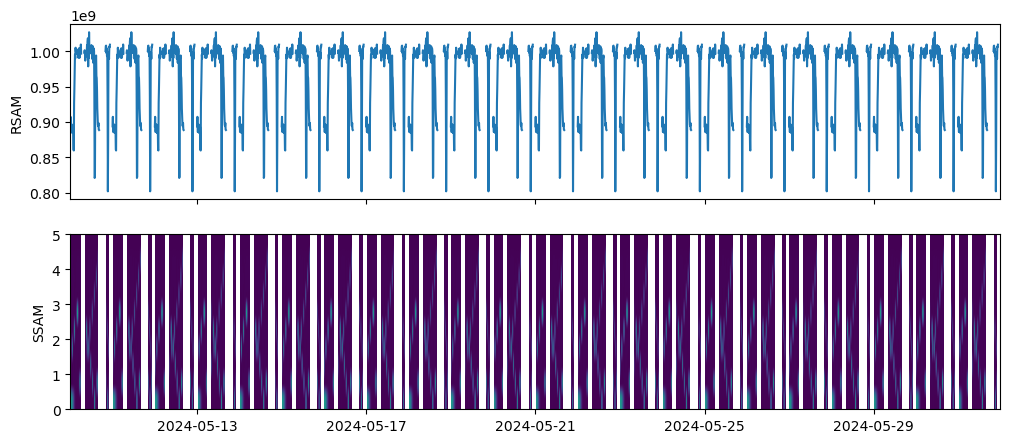

In [8]:
import matplotlib.pyplot as plt 
from tonik import Storage
import datetime

starttime = datetime.datetime(2024, 5, 10)
endtime = datetime.datetime(2024, 6, 1)
sg.starttime = starttime
sg.endtime = endtime 
store = sg.get_substore(site="WIZ", sensor="00", channel="HHZ")

rsam = store("rsam")
ssam = store("ssam")
print(rsam)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax1.plot(rsam.coords["datetime"], rsam.data)
ax1.set_ylabel("RSAM")
ax2.imshow(ssam.data, extent=[rsam.coords["datetime"][0].values, rsam.coords["datetime"][-1].values, 0, 5])
ax2.set_aspect("auto")
ax2.set_ylabel("SSAM")

Finally we can run some of the machine learning algorithm for anomaly detection. Note, that these depend on the scikit-learn and pytorch packages. You can install these dependencies by running:

In [ ]:
! python3 -m pip install -U "zizou[ML]"

Here we train an autoencoder with fuzzy clustering of the embeddings:

In [ ]:
from zizou.autoencoder import AutoEncoder

config = """
autoencoder: 
    layers: [2000,500,200,6]
    epochs: 1
    patience: 5
"""
model = AutoEncoder(config)

# Create the Feature Request
starttime = datetime.datetime(2024, 5, 1)
endtime = datetime.datetime(2024, 6, 1)
store.starttime = starttime
store.endtime = endtime

# -- Train the Auto-Encoder and save the model (this might take a while)
classifications = model.fit_transform(store)
print(store.path)
store.save(classifications)